# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [20]:
import os
import keras
import itertools

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
## 載入資料
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1)) 
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [11]:
## 建立類神經網路模型
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [17]:
## 超參數設定
"""
Set your required experiment parameters
"""
LEARNING_RATE = [1e-1, 1e-2, 1e-3, 1e-4,] ## 觀察不同的LR的影響
EPOCHS = 30
BATCH_SIZE = 256
MOMENTUM = [0.8, 0.9, 0.95, 0.99] # 觀察不同的動量有何變化

In [22]:
tuple(itertools.product(LEARNING_RATE, MOMENTUM))

((0.1, 0.8),
 (0.1, 0.9),
 (0.1, 0.95),
 (0.1, 0.99),
 (0.01, 0.8),
 (0.01, 0.9),
 (0.01, 0.95),
 (0.01, 0.99),
 (0.001, 0.8),
 (0.001, 0.9),
 (0.001, 0.95),
 (0.001, 0.99),
 (0.0001, 0.8),
 (0.0001, 0.9),
 (0.0001, 0.95),
 (0.0001, 0.99))

In [23]:
results = {}
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for lr, momentum in itertools.product(LEARNING_RATE, MOMENTUM): # itertools.product :笛卡爾積
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    ## Momentum 動量：<float> 參數，用於加速 SGD 在相關方向上前進，並抑制震盪
    optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=momentum)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with LR = 0.100000
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
196/196 [==============================] - 2s 11ms/step - loss: 2.098

196/196 [==============================] - 2s 10ms/step - loss: 1.4055 - accuracy: 0.4975 - val_loss: 1.5760 - val_accuracy: 0.4538
Epoch 14/30
196/196 [==============================] - 2s 10ms/step - loss: 1.3941 - accuracy: 0.5009 - val_loss: 1.6216 - val_accuracy: 0.4425
Epoch 15/30
196/196 [==============================] - 2s 10ms/step - loss: 1.3783 - accuracy: 0.5069 - val_loss: 1.5693 - val_accuracy: 0.4414
Epoch 16/30
196/196 [==============================] - 2s 10ms/step - loss: 1.3641 - accuracy: 0.5112 - val_loss: 1.7152 - val_accuracy: 0.4243
Epoch 17/30
196/196 [==============================] - 2s 10ms/step - loss: 1.3542 - accuracy: 0.5156 - val_loss: 1.5422 - val_accuracy: 0.4619
Epoch 18/30
196/196 [==============================] - 2s 10ms/step - loss: 1.3386 - accuracy: 0.5206 - val_loss: 1.5076 - val_accuracy: 0.4721
Epoch 19/30
196/196 [==============================] - 2s 10ms/step - loss: 1.3222 - accuracy: 0.5248 - val_loss: 1.6401 - val_accuracy: 0.4356
Epoc

Epoch 1/30
196/196 [==============================] - 3s 13ms/step - loss: 2.3426 - accuracy: 0.1092 - val_loss: 2.3067 - val_accuracy: 0.1000
Epoch 2/30
196/196 [==============================] - 2s 12ms/step - loss: 2.3058 - accuracy: 0.1008 - val_loss: 2.3054 - val_accuracy: 0.1000
Epoch 3/30
196/196 [==============================] - 2s 11ms/step - loss: 2.3064 - accuracy: 0.0991 - val_loss: 2.3105 - val_accuracy: 0.1000
Epoch 4/30
196/196 [==============================] - 2s 12ms/step - loss: 2.3063 - accuracy: 0.1018 - val_loss: 2.3057 - val_accuracy: 0.1000
Epoch 5/30
196/196 [==============================] - 2s 11ms/step - loss: 2.3057 - accuracy: 0.0996 - val_loss: 2.3077 - val_accuracy: 0.1000
Epoch 6/30
196/196 [==============================] - 2s 10ms/step - loss: 2.3070 - accuracy: 0.0999 - val_loss: 2.3040 - val_accuracy: 0.1000
Epoch 7/30
196/196 [==============================] - 2s 10ms/step - loss: 2.3068 - accuracy: 0.1001 - val_loss: 2.3048 - val_accuracy: 0.1000

Epoch 21/30
196/196 [==============================] - 2s 11ms/step - loss: 1.1435 - accuracy: 0.5984 - val_loss: 1.3835 - val_accuracy: 0.5172
Epoch 22/30
196/196 [==============================] - 2s 12ms/step - loss: 1.1229 - accuracy: 0.6065 - val_loss: 1.4726 - val_accuracy: 0.4907
Epoch 23/30
196/196 [==============================] - 2s 12ms/step - loss: 1.1057 - accuracy: 0.6096 - val_loss: 1.3379 - val_accuracy: 0.5330
Epoch 24/30
196/196 [==============================] - 2s 11ms/step - loss: 1.0923 - accuracy: 0.6162 - val_loss: 1.4852 - val_accuracy: 0.4918
Epoch 25/30
196/196 [==============================] - 2s 11ms/step - loss: 1.0696 - accuracy: 0.6229 - val_loss: 1.4042 - val_accuracy: 0.5040
Epoch 26/30
196/196 [==============================] - 2s 11ms/step - loss: 1.0509 - accuracy: 0.6298 - val_loss: 1.4233 - val_accuracy: 0.5017
Epoch 27/30
196/196 [==============================] - 2s 11ms/step - loss: 1.0359 - accuracy: 0.6374 - val_loss: 1.3516 - val_accuracy:

196/196 [==============================] - 2s 12ms/step - loss: 1.5137 - accuracy: 0.4607 - val_loss: 1.4977 - val_accuracy: 0.4721
Epoch 4/30
196/196 [==============================] - 2s 12ms/step - loss: 1.4524 - accuracy: 0.4838 - val_loss: 1.4997 - val_accuracy: 0.4744
Epoch 5/30
196/196 [==============================] - 2s 11ms/step - loss: 1.4003 - accuracy: 0.5024 - val_loss: 1.4433 - val_accuracy: 0.4875
Epoch 6/30
196/196 [==============================] - 2s 11ms/step - loss: 1.3545 - accuracy: 0.5186 - val_loss: 1.4852 - val_accuracy: 0.4779
Epoch 7/30
196/196 [==============================] - 2s 11ms/step - loss: 1.3205 - accuracy: 0.5302 - val_loss: 1.4496 - val_accuracy: 0.4832
Epoch 8/30
196/196 [==============================] - 2s 11ms/step - loss: 1.2845 - accuracy: 0.5430 - val_loss: 1.4881 - val_accuracy: 0.4798
Epoch 9/30
196/196 [==============================] - 2s 11ms/step - loss: 1.2552 - accuracy: 0.5506 - val_loss: 1.4649 - val_accuracy: 0.4870
Epoch 10/3

Epoch 23/30
196/196 [==============================] - 2s 11ms/step - loss: 1.0384 - accuracy: 0.6308 - val_loss: 1.4949 - val_accuracy: 0.4976
Epoch 24/30
196/196 [==============================] - 2s 11ms/step - loss: 1.0479 - accuracy: 0.6254 - val_loss: 1.5213 - val_accuracy: 0.5021
Epoch 25/30
196/196 [==============================] - 2s 11ms/step - loss: 1.0201 - accuracy: 0.6337 - val_loss: 1.5221 - val_accuracy: 0.5166
Epoch 26/30
196/196 [==============================] - 2s 11ms/step - loss: 0.9964 - accuracy: 0.6446 - val_loss: 1.5298 - val_accuracy: 0.5139
Epoch 27/30
196/196 [==============================] - 2s 11ms/step - loss: 0.9836 - accuracy: 0.6476 - val_loss: 1.5694 - val_accuracy: 0.4952
Epoch 28/30
196/196 [==============================] - 2s 11ms/step - loss: 0.9817 - accuracy: 0.6455 - val_loss: 1.5321 - val_accuracy: 0.5067
Epoch 29/30
196/196 [==============================] - 2s 11ms/step - loss: 0.9674 - accuracy: 0.6523 - val_loss: 1.5414 - val_accuracy:

196/196 [==============================] - 2s 11ms/step - loss: 1.7045 - accuracy: 0.4047 - val_loss: 1.7005 - val_accuracy: 0.4068
Epoch 6/30
196/196 [==============================] - 2s 11ms/step - loss: 1.6715 - accuracy: 0.4150 - val_loss: 1.6615 - val_accuracy: 0.4205
Epoch 7/30
196/196 [==============================] - 2s 13ms/step - loss: 1.6413 - accuracy: 0.4265 - val_loss: 1.6451 - val_accuracy: 0.4248
Epoch 8/30
196/196 [==============================] - 2s 13ms/step - loss: 1.6154 - accuracy: 0.4363 - val_loss: 1.6137 - val_accuracy: 0.4365
Epoch 9/30
196/196 [==============================] - 2s 12ms/step - loss: 1.5923 - accuracy: 0.4437 - val_loss: 1.6113 - val_accuracy: 0.4362
Epoch 10/30
196/196 [==============================] - 2s 12ms/step - loss: 1.5725 - accuracy: 0.4518 - val_loss: 1.5768 - val_accuracy: 0.4471
Epoch 11/30
196/196 [==============================] - 2s 12ms/step - loss: 1.5529 - accuracy: 0.4577 - val_loss: 1.5658 - val_accuracy: 0.4505
Epoch 12

Epoch 25/30
196/196 [==============================] - 2s 11ms/step - loss: 1.1961 - accuracy: 0.5798 - val_loss: 1.3554 - val_accuracy: 0.5227
Epoch 26/30
196/196 [==============================] - 2s 11ms/step - loss: 1.1802 - accuracy: 0.5867 - val_loss: 1.4063 - val_accuracy: 0.5040
Epoch 27/30
196/196 [==============================] - 2s 11ms/step - loss: 1.1672 - accuracy: 0.5884 - val_loss: 1.3587 - val_accuracy: 0.5193
Epoch 28/30
196/196 [==============================] - 2s 11ms/step - loss: 1.1535 - accuracy: 0.5941 - val_loss: 1.3507 - val_accuracy: 0.5260
Epoch 29/30
196/196 [==============================] - 2s 11ms/step - loss: 1.1400 - accuracy: 0.5995 - val_loss: 1.3732 - val_accuracy: 0.5123
Epoch 30/30
196/196 [==============================] - 2s 11ms/step - loss: 1.1262 - accuracy: 0.6062 - val_loss: 1.3250 - val_accuracy: 0.5311
Experiment with LR = 0.001000
Model: "functional_1"
_________________________________________________________________
Layer (type)      

196/196 [==============================] - 2s 10ms/step - loss: 2.0816 - accuracy: 0.2619 - val_loss: 2.0738 - val_accuracy: 0.2701
Epoch 8/30
196/196 [==============================] - 2s 10ms/step - loss: 2.0623 - accuracy: 0.2713 - val_loss: 2.0553 - val_accuracy: 0.2784
Epoch 9/30
196/196 [==============================] - 2s 10ms/step - loss: 2.0447 - accuracy: 0.2801 - val_loss: 2.0386 - val_accuracy: 0.2820
Epoch 10/30
196/196 [==============================] - 2s 10ms/step - loss: 2.0288 - accuracy: 0.2856 - val_loss: 2.0234 - val_accuracy: 0.2902
Epoch 11/30
196/196 [==============================] - 2s 10ms/step - loss: 2.0141 - accuracy: 0.2917 - val_loss: 2.0093 - val_accuracy: 0.2958
Epoch 12/30
196/196 [==============================] - 2s 10ms/step - loss: 2.0004 - accuracy: 0.2978 - val_loss: 1.9967 - val_accuracy: 0.2932
Epoch 13/30
196/196 [==============================] - 2s 10ms/step - loss: 1.9880 - accuracy: 0.3012 - val_loss: 1.9848 - val_accuracy: 0.3081
Epoch 

Epoch 27/30
196/196 [==============================] - 2s 12ms/step - loss: 1.8094 - accuracy: 0.3720 - val_loss: 1.8122 - val_accuracy: 0.3700
Epoch 28/30
196/196 [==============================] - 2s 12ms/step - loss: 1.8038 - accuracy: 0.3729 - val_loss: 1.8052 - val_accuracy: 0.3703
Epoch 29/30
196/196 [==============================] - 2s 11ms/step - loss: 1.7980 - accuracy: 0.3756 - val_loss: 1.8011 - val_accuracy: 0.3762
Epoch 30/30
196/196 [==============================] - 2s 11ms/step - loss: 1.7925 - accuracy: 0.3772 - val_loss: 1.7941 - val_accuracy: 0.3769
Experiment with LR = 0.000100
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
__________________________________________

196/196 [==============================] - 2s 10ms/step - loss: 1.6329 - accuracy: 0.4307 - val_loss: 1.6277 - val_accuracy: 0.4315
Epoch 10/30
196/196 [==============================] - 2s 10ms/step - loss: 1.6080 - accuracy: 0.4386 - val_loss: 1.6113 - val_accuracy: 0.4304
Epoch 11/30
196/196 [==============================] - 2s 10ms/step - loss: 1.5884 - accuracy: 0.4455 - val_loss: 1.5902 - val_accuracy: 0.4433
Epoch 12/30
196/196 [==============================] - 2s 10ms/step - loss: 1.5688 - accuracy: 0.4508 - val_loss: 1.5773 - val_accuracy: 0.4402
Epoch 13/30
196/196 [==============================] - 2s 10ms/step - loss: 1.5510 - accuracy: 0.4561 - val_loss: 1.5660 - val_accuracy: 0.4449
Epoch 14/30
196/196 [==============================] - 2s 10ms/step - loss: 1.5335 - accuracy: 0.4626 - val_loss: 1.5457 - val_accuracy: 0.4547
Epoch 15/30
196/196 [==============================] - 2s 10ms/step - loss: 1.5164 - accuracy: 0.4702 - val_loss: 1.5326 - val_accuracy: 0.4589
Epoc

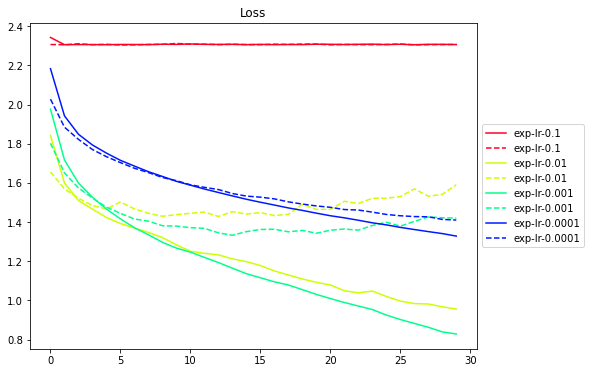

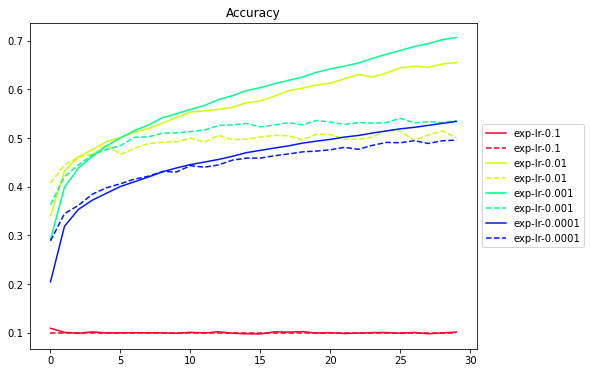

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline 
    
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()